In [28]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import joblib

In [29]:
# Load the dataset
df = pd.read_csv('processed_coconut_data.csv')
df.head(2)

,Date,Soil Moisture (10 cm) (%),Soil Moisture (20 cm) (%),Soil Moisture (30 cm) (%),Plant Age (years),Temperature (°C),Humidity (%),Rainfall (mm),Rain Status (0/1),Coconut Count
0,1930-05-31,20.23136,31.033891,41.227105,5,27.823293,64.297799,5.281903,1,307.90744
1,1930-06-30,20.23136,31.033891,41.227105,4,27.823293,64.297799,5.281903,1,307.90744


In [30]:
X = df.drop(['Date','Rain Status (0/1)','Coconut Count'], axis=1) 
y = df['Coconut Count']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Initialize models
models = {
   'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
   'XGBoost': XGBRegressor(n_estimators=100, random_state=42),
   'SVR': SVR(kernel='rbf', C=1.0, epsilon=0.1),
   'ANN': MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
   'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [33]:
from sklearn.metrics import mean_squared_error

def calculate_accuracy(y_true, y_pred):
   mse = mean_squared_error(y_true, y_pred)
   rmse = np.sqrt(mse)
   accuracy = 100 * (1 - rmse / np.mean(y_true))
   return max(0, accuracy)

In [34]:
results = {}
best_score = float('-inf')
best_model = None

for name, model in models.items():
   model.fit(X_train, y_train)
   y_pred = model.predict(X_test)
   
   accuracy = calculate_accuracy(y_test, y_pred)
   r2 = r2_score(y_test, y_pred) * 100  # Convert to percentage
   cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
   cv_percentage = cv_scores.mean() * 100
   
   results[name] = {
       'Accuracy': accuracy,
       'R2_Percentage': r2,
       'CV_Accuracy': cv_percentage,
       'CV_std': cv_scores.std() * 100
   }
   
   if cv_scores.mean() > best_score:
       best_score = cv_scores.mean()
       best_model = model

In [35]:
# Print results
print("Model Comparison Results:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"Accuracy: {metrics['Accuracy']:.2f}%")
    print(f"R2 Score: {metrics['R2_Percentage']:.2f}%")
    print(f"Cross-val R2: {metrics['CV_Accuracy']:.2f}% (+/- {metrics['CV_std']*2:.2f}%)")

print("\nBest Model Selected:", 
      [name for name, model in models.items() if model == best_model][0])

Model Comparison Results:

Random Forest:
Accuracy: 89.55%
R2 Score: -0.53%
Cross-val R2: -7.19% (+/- 12.65%)

XGBoost:
Accuracy: 89.27%
R2 Score: -6.05%
Cross-val R2: -32.20% (+/- 15.58%)

SVR:
Accuracy: 89.62%
R2 Score: 0.79%
Cross-val R2: 0.05% (+/- 0.50%)

ANN:
Accuracy: 89.07%
R2 Score: -10.10%
Cross-val R2: -18.02% (+/- 23.08%)

Gradient Boosting:
Accuracy: 89.49%
R2 Score: -1.84%
Cross-val R2: -10.63% (+/- 14.43%)

Best Model Selected: SVR


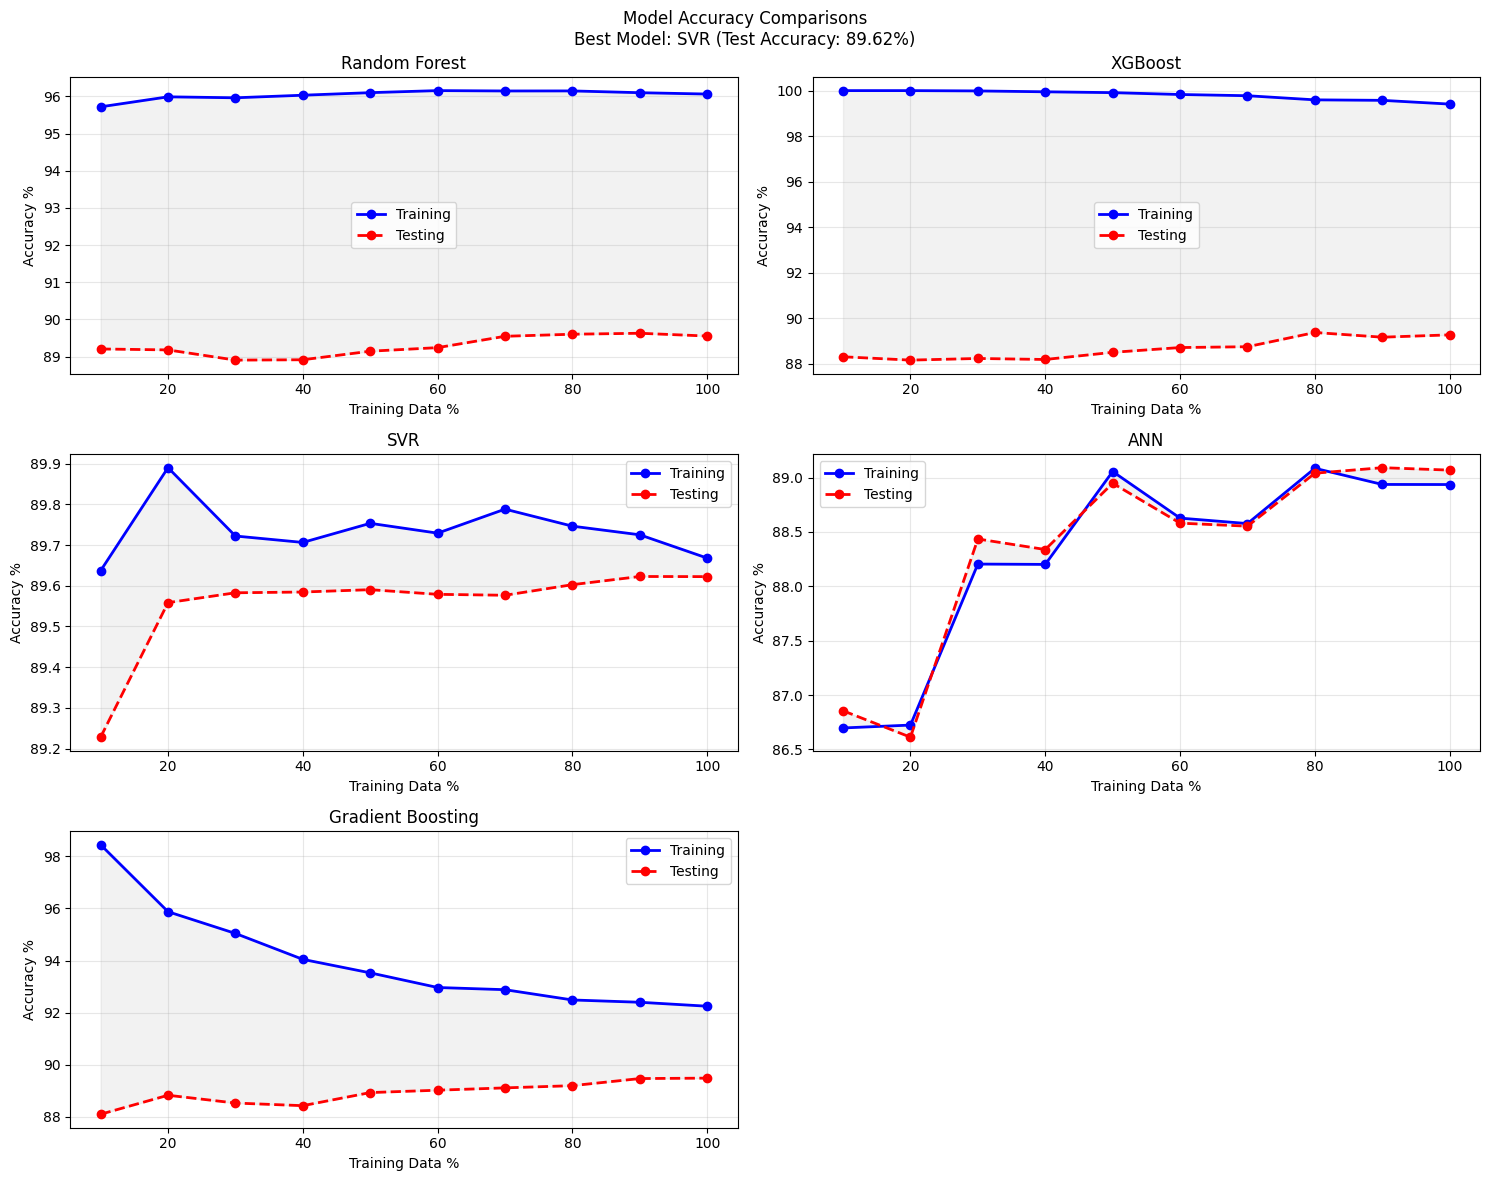

In [40]:
def plot_models_accuracy(models, X_train, X_test, y_train, y_test):
   time_points = np.linspace(0.1, 1.0, 10)
   n_samples = len(X_train)
   colors = {'Train': 'blue', 'Test': 'red'}
   best_test_acc = -np.inf
   best_model_name = None
   
   # Create figure with 3x2 subplots
   fig, axes = plt.subplots(3, 2, figsize=(15, 12))
   axes = axes.ravel()
   
   for idx, (name, model) in enumerate(models.items()):
       train_accuracies = []
       test_accuracies = []
       
       for fraction in time_points:
           n_subset = int(n_samples * fraction)
           X_subset = X_train[:n_subset]
           y_subset = y_train[:n_subset]
           
           model.fit(X_subset, y_subset)
           train_pred = model.predict(X_subset)
           test_pred = model.predict(X_test)
           
           train_acc = calculate_accuracy(y_subset, train_pred)
           test_acc = calculate_accuracy(y_test, test_pred)
           
           train_accuracies.append(train_acc)
           test_accuracies.append(test_acc)
           
           # Track best model
           if test_acc > best_test_acc and fraction == 1.0:
               best_test_acc = test_acc
               best_model_name = name
       
       axes[idx].plot(time_points * 100, train_accuracies, '-o', 
                     color=colors['Train'], label='Training', linewidth=2)
       axes[idx].plot(time_points * 100, test_accuracies, '--o', 
                     color=colors['Test'], label='Testing', linewidth=2)
       
       axes[idx].fill_between(time_points * 100, train_accuracies, 
                            test_accuracies, alpha=0.1, color='gray')
       
       axes[idx].set_xlabel('Training Data %')
       axes[idx].set_ylabel('Accuracy %')
       axes[idx].set_title(f'{name}')
       axes[idx].legend()
       axes[idx].grid(True, alpha=0.3)
       
   # Remove empty subplot
   axes[-1].remove()
   
   plt.suptitle(f'Model Accuracy Comparisons\nBest Model: {best_model_name} (Test Accuracy: {best_test_acc:.2f}%)', 
                size=12)
   plt.tight_layout()
   plt.show()

# Call function
plot_models_accuracy(models, X_train, X_test, y_train, y_test)

In [37]:
# Save the model to a file
joblib.dump(best_model, 'best_yield_predictor.pkl')

['best_yield_predictor.pkl']

In [38]:
# Load the model from the file
loaded_model = joblib.load('best_yield_predictor.pkl')

# Example new input data (as a DataFrame)
new_data = pd.DataFrame({
    'Soil Moisture (10 cm) (%)': [19.89],
    'Soil Moisture (20 cm) (%)': [41.67],
    'Soil Moisture (30 cm) (%)': [34.82],
    'Plant Age (years)':[3],
    'Temperature (°C)':[32.68],
    'Humidity (%)':[60.87],
    'Rainfall (mm)':[0],  # Corrected feature name
})

# Predict the oil yield for new data
predicted_yield = loaded_model.predict(new_data)
print("\nPredicted Coconut Yield:", predicted_yield[0])


Predicted Coconut Yield: 298.42823339670366
